In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

colours = ['tab:blue','tab:orange','tab:green','tab:red'] # just used for plotting


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

In [3]:
''' ------------ load data ---------- '''
# loop through the csvs and load them in order, creating a single large pandas dataframe

feature_columns = ['Temp (ºC)', 'Rel Hum (%)','Wind Spd (km/h)', 'Stn Press (kPa)']

data = []
for _year in tqdm(np.arange(2018,2024)):
    _year = str(_year)
    for _month in np.arange(1,13):
        _month = str(_month).rjust(2).replace(' ','0')
        if (_year == '2023') & (_month == '07'): break # don't load beyond date of download (just a lot of nans)

        combo_path = f'drive/MyDrive/roko/airport/en_climate_hourly_BC_1018621_{_month}-{_year}_P1H.csv'
        data.append(pd.read_csv(combo_path))

data_df = pd.concat(data)
data_df = data_df.reset_index()


  0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
''' ------------ replace '°' with 'º' -----------'''
# also drop unused/ or static columns

for _col in data_df.columns:
  if '°' in _col:
    data_df = data_df.rename(columns = {_col:_col.replace('°','º')})

# drop static columns
data_df = data_df.drop(columns = {'index', 'Longitude (x)', 'Latitude (y)', 'Climate ID',
                                  'Station Name', 'Date/Time (LST)',
                                  'Temp Flag','Dew Point Temp Flag','Wind Spd Flag', 'Visibility Flag',
                                  'Stn Press Flag','Hmdx Flag','Wind Chill Flag','Rel Hum Flag',
                                  'Precip. Amount Flag','Wind Dir Flag','Precip. Amount (mm)'})

data_df[:5]

,Year,Month,Day,Time (LST),Temp (ºC),Dew Point Temp (ºC),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather
0,2018,1,1,00:00,0.7,-0.2,94.0,28.0,8.0,32.2,102.49,NaN,NaN,NaN
1,2018,1,1,01:00,1.2,0.0,92.0,28.0,9.0,32.2,102.54,NaN,NaN,Mostly Cloudy
2,2018,1,1,02:00,1.3,0.0,91.0,28.0,12.0,32.2,102.59,NaN,NaN,NaN
3,2018,1,1,03:00,1.4,0.2,92.0,29.0,9.0,32.2,102.62,NaN,NaN,NaN
4,2018,1,1,04:00,1.4,0.2,92.0,30.0,13.0,24.1,102.64,NaN,NaN,Cloudy


In [5]:
''' find nans in temperature channel '''
# make a mask
# summing mask gives the number of "True" values

print(np.isnan(data_df['Temp (ºC)']).sum()) # 47 instances in "temp" where data doesn't exist

47


In [6]:
''' remove nans by filling in with previous value '''

continuous_columns = ['Temp (ºC)','Rel Hum (%)', 'Dew Point Temp (ºC)',
                      'Wind Dir (10s deg)', 'Wind Spd (km/h)',
                      'Visibility (km)', 'Stn Press (kPa)']
# syntax from: https://stackoverflow.com/questions/27012151/forward-fill-specific-columns-in-pandas-dataframe
# (I have to look up pandas syntax for just about everything)
data_df.loc[:,continuous_columns] = data_df.loc[:,continuous_columns].ffill()

data_df[:5]

,Year,Month,Day,Time (LST),Temp (ºC),Dew Point Temp (ºC),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather
0,2018,1,1,00:00,0.7,-0.2,94.0,28.0,8.0,32.2,102.49,NaN,NaN,NaN
1,2018,1,1,01:00,1.2,0.0,92.0,28.0,9.0,32.2,102.54,NaN,NaN,Mostly Cloudy
2,2018,1,1,02:00,1.3,0.0,91.0,28.0,12.0,32.2,102.59,NaN,NaN,NaN
3,2018,1,1,03:00,1.4,0.2,92.0,29.0,9.0,32.2,102.62,NaN,NaN,NaN
4,2018,1,1,04:00,1.4,0.2,92.0,30.0,13.0,24.1,102.64,NaN,NaN,Cloudy


## Visualize Data

What are the features? How much data do we have? What are the trends?

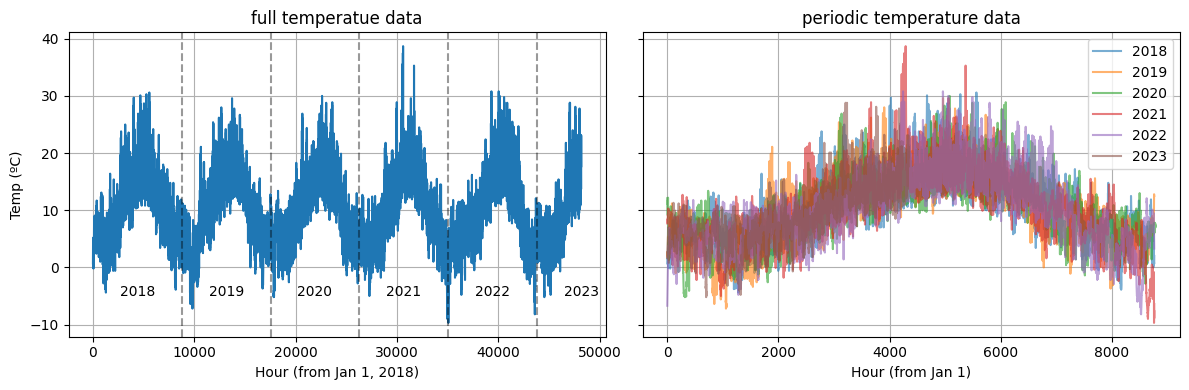

In [ ]:
''' ---------- visualize temperature change ------------- '''

fig,ax = plt.subplots(1,2,figsize=(12,4), sharey=True)
ax[0].plot(data_df['Temp (ºC)'])
ax[0].set_xlabel('Hour (from Jan 1, 2018)')
ax[0].set_ylabel('Temp (ºC)')
ax[0].grid()
ax[0].set_title('full temperatue data')
for i in range(1,6): # year breaks
  ax[0].axvline(24*365*i,ls='--',c='k',alpha=0.4)

for i,k in enumerate([2018, 2019, 2020, 2021, 2022, 2023]):
  temp_data = data_df[data_df['Year']==k]
  ax[1].plot(np.arange(len(temp_data)), temp_data['Temp (ºC)'],label=k, alpha=0.6)
  ax[0].text(8760*i+4380, -5, k, ha='center')
ax[1].legend(); ax[1].grid()
ax[1].set_xlabel('Hour (from Jan 1)')
ax[1].set_title('periodic temperature data')
plt.tight_layout()

In [9]:
''' ----------- look at moving average values for a single year  ----------- '''

def moving_avg(data, window):
  cumsum = np.convolve(data, np.ones(window), 'valid') / window
  indices = np.linspace(0,len(data), num = len(cumsum))
  return indices, cumsum


plt.title('year 2022 temperatue data')
temp_data = data_df[data_df['Year']==2022] # a full year

plt.plot(np.array(temp_data['Temp (ºC)']), label='hourly')
plt.plot(*moving_avg(np.array(temp_data['Temp (ºC)']), window=24),label='daily moving average')
plt.plot(*moving_avg(np.array(temp_data['Temp (ºC)']), window=24*7),label='weekly moving average', c='k')
plt.legend(); plt.grid(); plt.xlabel('hour index'); plt.ylabel('Temperature')

In [ ]:
''' ---- look at the 5 year variation of each feature -- '''

features = dict()
features['Temp'] = np.full((8760, 6), fill_value = np.nan)
features['Hum'] = np.full((8760, 6), fill_value = np.nan)
features['Wind'] = np.full((8760, 6), fill_value = np.nan)
features['Press'] = np.full((8760, 6), fill_value = np.nan)

for i,k in enumerate([2018, 2019, 2020, 2021, 2022, 2023]):
  temp_data = data_df[data_df['Year']==k]
  if k == 2020: # erase the leap day in 2020. (causes problems in this visualization. won't be removed from training)
    temp_data = pd.concat([temp_data[:1416], temp_data[1416+24:]]) # indices remove Feb 29th.
  features['Temp'][:len(temp_data),i] = temp_data['Temp (ºC)']
  features['Hum'][:len(temp_data),i] = temp_data['Rel Hum (%)']
  features['Wind'][:len(temp_data),i] = temp_data['Wind Spd (km/h)']
  features['Press'][:len(temp_data),i] = temp_data['Stn Press (kPa)']


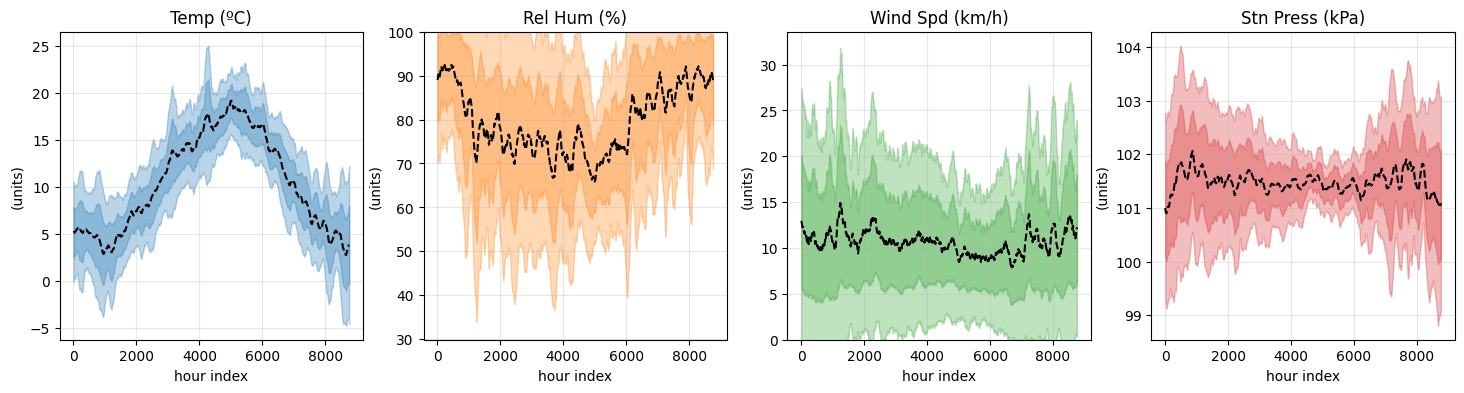

In [ ]:
''' --------- visualize yearly variation ----------- '''
# dashed line is the mean value (weekly moving average)
# the two "fill_between"s are 1 and 2 standard deviation.

fig,ax = plt.subplots(1,4,figsize=(18,4))

for idx, (i,k) in enumerate(features.items()):
  temp_nanmean = np.nanmean(k, axis=1)
  temp_nanstd = np.nanstd(k, axis=1)

  ax[idx].fill_between(moving_avg(temp_nanmean,window=24*7)[0],
                    moving_avg(temp_nanmean - temp_nanstd,window=24*7)[1],
                    moving_avg(temp_nanmean + temp_nanstd,window=24*7)[1]
                  ,alpha = 0.3, color = colours[idx])
  ax[idx].fill_between(moving_avg(temp_nanmean,window=24*7)[0],
                    moving_avg(temp_nanmean - 2 * temp_nanstd,window=24*7)[1],
                    moving_avg(temp_nanmean + 2 * temp_nanstd,window=24*7)[1]
                  ,alpha = 0.3, color = colours[idx])
  ax[idx].plot(*moving_avg(temp_nanmean,window=24*7),c='k',ls='--')
  ax[idx].set_title(feature_columns[idx]); ax[idx].grid(alpha=0.3); ax[idx].set_xlabel('hour index'); ax[idx].set_ylabel('(units)')

ax[1].set_ylim(None,100);ax[2].set_ylim(0,None);

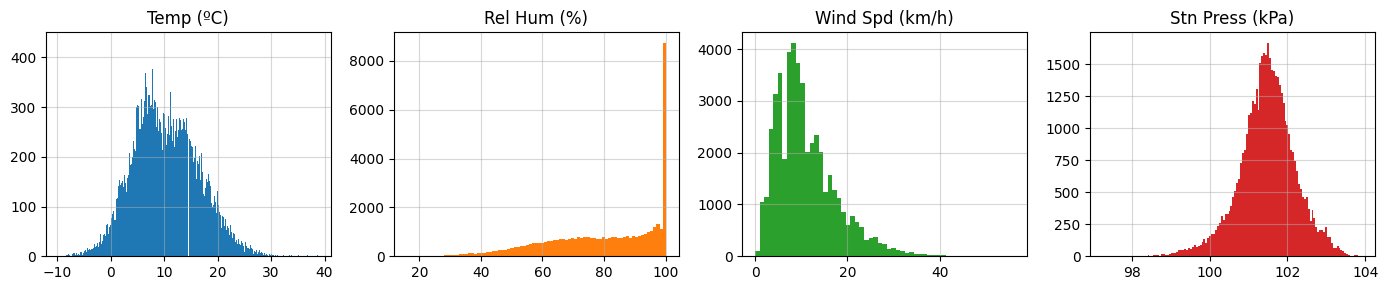

In [ ]:
''' visualize distribution of each feature '''
# notice the values and variation. Relative Humidity has large values and a wide range, whereas Stn Press has high values but low variance
resolution = [0.1,1,1,0.05]

fig,ax = plt.subplots(1,4,figsize=(14,3))
for idx, _col in enumerate(feature_columns):
  n_bins = len(np.arange(min(data_df[_col]), max(data_df[_col]), resolution[idx]))+1
  ax[idx].hist(data_df[_col], bins=n_bins, color=colours[idx])
  ax[idx].set_title(_col);ax[idx].grid(alpha=0.5);
plt.tight_layout()

## Break timeseries into hourly samples (Preprocess)

In [7]:
''' define some functions '''
def timeseries_split(data, step = 1, window = 48):
  '''
  splits a timeseries into samples of a given size

  data: is an array (timesteps, features)
  step: is the offset between subsequent samples
  window: is how much data to put in the sample (automatically adds the t+1 prediction)
  '''
  samples=list()
  for i in range(int((len(data)-(window+1))/step)):
    data_temp = data[(i*step):(i*step) + window + 1]
    samples.append(data_temp)
  return np.array(samples)

## Move into forecasting

How many datapoints as input?

What time resolution (hourly, daily?)

In [8]:
''' ------ create samples by dividing timeseries ------ '''
# split data into hourly chunks (24 hours as input, predict the 6 hour)
training_samples = timeseries_split(data_df['Temp (ºC)'], # the data to split up
                                    window = 24 + 5,   # 24 hours input, predict 6th hour ahead
                                    step = 1)   # spacing between samples


### Hourly

In [ ]:
''' define a simple neural network '''
def build_cnn(timesteps):
    xin = tf.keras.layers.Input((timesteps))
    x0 = tf.keras.layers.Reshape((-1,1))(xin) # add dumby channel
    x0 = tf.keras.layers.Conv1D(32, 3, activation='swish',padding='same')(x0)
    x0 = tf.keras.layers.Conv1D(32, 3, activation='swish',padding='same')(x0)
    x0 = tf.keras.layers.Conv1D(32, 3, activation='swish',padding='same')(x0)
    x0 = tf.keras.layers.Flatten()(x0)

    x0 = tf.keras.layers.Dense(64,activation='swish')(x0)
    x0 = tf.keras.layers.Dropout(0.1)(x0)

    x0 = tf.keras.layers.Dense(1)(x0)
    return tf.keras.models.Model(xin,x0)

build_cnn(timesteps=24).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24)]              0         
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 24, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 24, 32)            3104      
                                                                 
 conv1d_2 (Conv1D)           (None, 24, 32)            3104      
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 64)                49216 

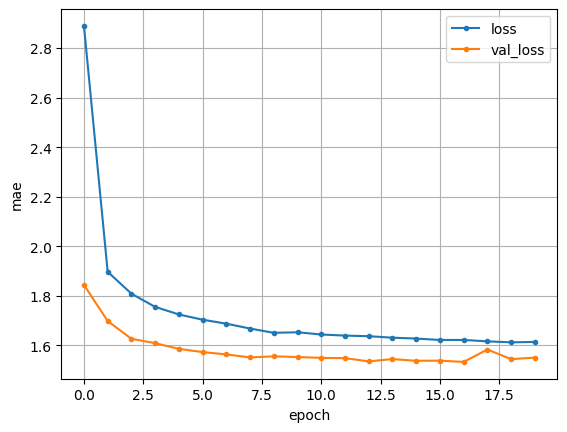

In [ ]:
''' train a model '''

# define a model
my_cnn = build_cnn(timesteps=24)

# compile
my_cnn.compile(loss='mae',
               optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5))

# train
hist = my_cnn.fit(x = training_samples[:, :24], # (samples, timesteps)
                  y = training_samples[:, -1],  # (samples, last timestep)
                  batch_size = 128,
                  epochs = 20,
                  validation_split=0.05,
                  verbose=0)

plt.plot(hist.history['loss'],label='loss',marker='.')
plt.plot(hist.history['val_loss'],label='val_loss',marker='.')
plt.legend(); plt.grid();plt.ylabel('mae');plt.xlabel('epoch');

In [ ]:
# make prediction to see if we're getting a good prediction on training data
# (no need to jump to test set if it performs poorly on training)
cnn_pred = my_cnn.predict(training_samples[:,:24]).squeeze()


### Evaluate

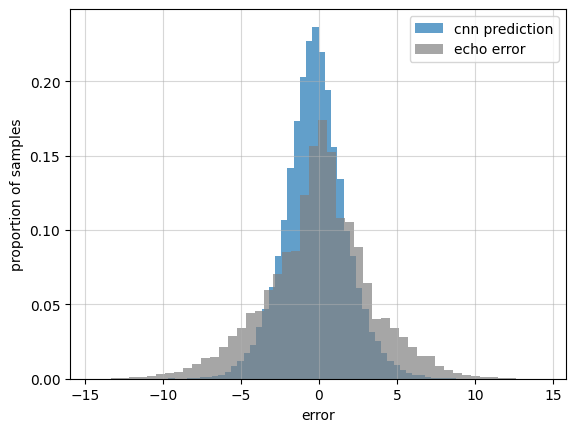

In [ ]:
''' --- simple cnn prediction vs naive method ----'''

# the naive method is, "What was the most recent feature value?"
# which I call "echo", because it echos the previous value.

plt.hist(cnn_pred - training_samples[:,-1],
         bins=50,alpha=0.7,density=True,label='cnn prediction')

plt.hist(training_samples[:,24] - training_samples[:,-1],
             bins=50,alpha=0.7,density=True,label='echo error',color='gray');
plt.legend()
plt.ylabel('proportion of samples')
plt.xlabel('error')
plt.grid(alpha=0.5)

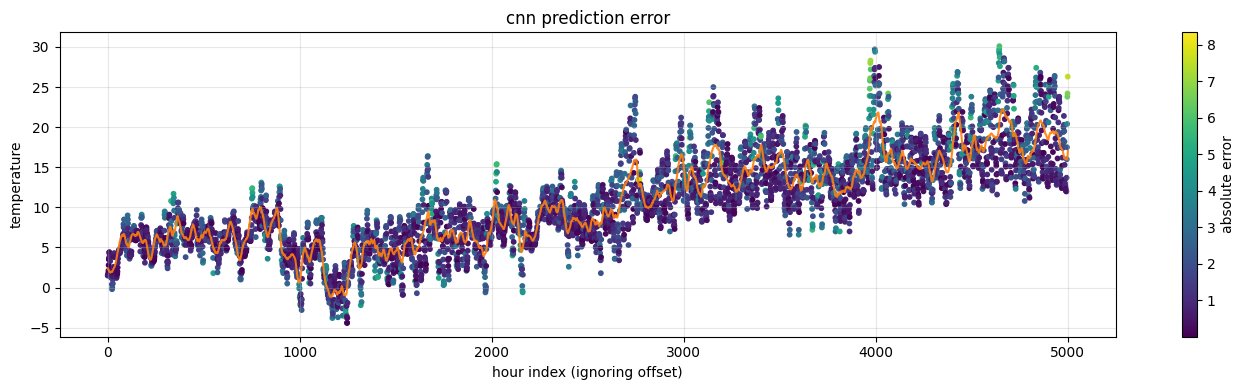

In [ ]:
''' ------ visualize errors -------- '''
# it can be helpful to visualize where the model is making errors to understand how the model could be improved.
# these look at what the error is at each sample (what the actual temperature is and coloured by how wrong the model is)

window = 5000
plt.figure(figsize=(14,4))
plt.title('cnn prediction error')
plt.scatter(np.arange(len(training_samples[:window])),
            training_samples[:window,-1],
            c=abs(cnn_pred[:window] - training_samples[:window,-1]),
            s=10)
plt.plot(*moving_avg(training_samples[:window,-1],window=24),c=colours[1],alpha=0.9, label='daily moving average')
plt.grid(alpha=0.3)
plt.colorbar(label='absolute error')
plt.ylabel('temperature');
plt.xlabel('hour index (ignoring offset)')
plt.tight_layout()
# things to note here: highest errors are at outliers, which seems about right

In [ ]:
# how many hourly predictions are off by 5º?

mask = (abs(cnn_pred - training_samples[:,-1]) > 5)
mask.sum()

936

In [9]:
# re evaluate with a smarter baseline
# train a linear model (no non-linearities)
# could also use LinearRegression from sklearn (this would be more efficient)

def build_better_baseline(timesteps):
    xin = tf.keras.layers.Input((timesteps))
    x0 = tf.keras.layers.Dense(1)(xin)
    return tf.keras.models.Model(xin,x0)

build_better_baseline(timesteps=24).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24)]              0         
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


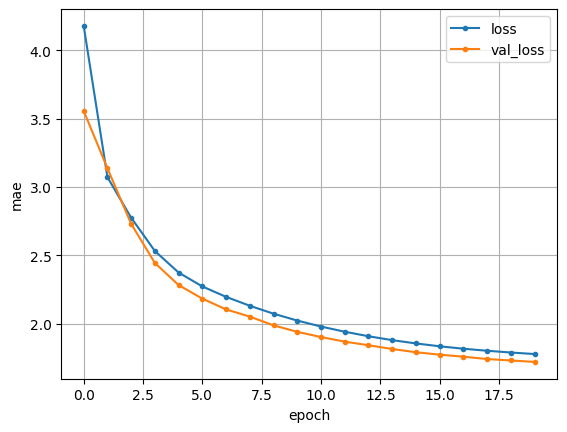

In [10]:
''' train a better baseline '''

# define a model
my_baseline = build_better_baseline(timesteps=24)

# compile
my_baseline.compile(loss='mae',
                    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4))

# train
hist = my_baseline.fit(x = training_samples[:, :24], # (samples, timesteps)
                       y = training_samples[:, -1],  # (samples, last timestep)
                       batch_size = 64,
                       epochs = 20,
                       validation_split=0.05,
                       verbose=0)

plt.plot(hist.history['loss'],label='loss',marker='.')
plt.plot(hist.history['val_loss'],label='val_loss',marker='.')
plt.legend(); plt.grid();
plt.xlabel('epoch');plt.ylabel('mae');

1505/1505 [==============================] - 2s 1ms/step


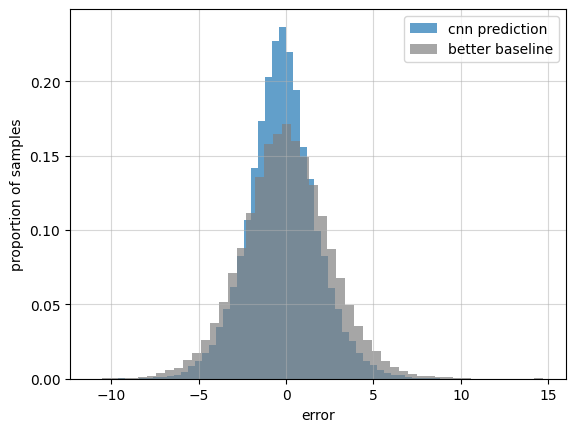

In [ ]:
# make prediction to see if we're getting a good prediction on training data
# (no need to jump to test set if it performs poorly on training)
baseline_pred = my_baseline.predict(training_samples[:,:24]).squeeze()


''' --- simple cnn prediction vs better baseline ----'''

plt.hist(cnn_pred - training_samples[:,-1],
         bins=50,alpha=0.7,density=True,label='cnn prediction')

plt.hist(baseline_pred - training_samples[:,-1],
             bins=50,alpha=0.7,density=True,label='better baseline',color='gray');

plt.legend()
plt.ylabel('proportion of samples')
plt.xlabel('error')
plt.grid(alpha=0.5)


**ENDED HERE** (October 11, 2023)

TF Week 4 continues here with timeseries and looks at recurrent NNs

In [12]:
''' define a model with two separate input features'''
# we need to divide up the training data for humidity (our other feature)
# use the same data set
training_samples_humidity = timeseries_split(data_df['Rel Hum (%)'], # the data to split up
                                    window = 24 + 5,   # 24 hours input, predict 6th hour ahead
                                    step = 1)   # spacing between samples

# preprocessing of data (to put them in the same-ish range)
# divide humidity by 100 to get it into the range of 0-1
# divide temperature by 40 to put it somewhere in similar range (-0.5 to 1.0 ?)
training_samples_humidity /= 100
training_samples /= 40


def build_multi_input(timesteps):
  # we are predicting two values, temperature and humidity together

  # x0 branch
  # takes temperature in
  xin0 = tf.keras.layers.Input((timesteps), name='temperature input')
  x0 = tf.keras.layers.Reshape((-1,1))(xin0)
  x0 = tf.keras.layers.Conv1D(32,6,activation='swish',padding='same')(x0)
  x0 = tf.keras.layers.Flatten()(x0)

  # x1 branch
  # takes humidity in
  xin1 = tf.keras.layers.Input((timesteps), name = 'humidity input')
  x1 = tf.keras.layers.Reshape((-1,1))(xin1)
  x1 = tf.keras.layers.Conv1D(32,6,activation='swish',padding='same')(x1)
  x1 = tf.keras.layers.Flatten()(x1)

  # concat
  # merge the two branches to the main model
  x2 = tf.keras.layers.Concatenate()([x0, x1])
  x2 = tf.keras.layers.Dense(128,activation='swish')(x2)
  x2 = tf.keras.layers.Dense(2)(x2)

  return tf.keras.models.Model(inputs = [xin0, xin1], # multiple inputs are presented as a list.
                               outputs = x2)

build_multi_input(timesteps=24).summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 temperature input (InputLa  [(None, 24)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 humidity input (InputLayer  [(None, 24)]                 0         []                            
 )                                                                                                
                                                                                                  
 reshape (Reshape)           (None, 24, 1)                0         ['temperature input[0][0]']   
                                                                                            

In [13]:
# the target of the model (what we want the model to approximate)
combined_target = np.vstack([training_samples[:,-1], # temperature
                             training_samples_humidity[:,-1]]).T # humidity
combined_target.shape # should be (-1, 2)

(48138, 2)

Epoch 1/20
358/358 [==============================] - 9s 5ms/step - loss: 0.0942 - val_loss: 0.0755
Epoch 2/20
358/358 [==============================] - 1s 4ms/step - loss: 0.0698 - val_loss: 0.0735
Epoch 3/20
358/358 [==============================] - 1s 4ms/step - loss: 0.0676 - val_loss: 0.0708
Epoch 4/20
358/358 [==============================] - 1s 4ms/step - loss: 0.0662 - val_loss: 0.0694
Epoch 5/20
358/358 [==============================] - 1s 4ms/step - loss: 0.0655 - val_loss: 0.0680
Epoch 6/20
358/358 [==============================] - 1s 3ms/step - loss: 0.0649 - val_loss: 0.0687
Epoch 7/20
358/358 [==============================] - 1s 4ms/step - loss: 0.0647 - val_loss: 0.0685
Epoch 8/20
358/358 [==============================] - 1s 4ms/step - loss: 0.0645 - val_loss: 0.0693
Epoch 9/20
358/358 [==============================] - 2s 5ms/step - loss: 0.0643 - val_loss: 0.0677
Epoch 10/20
358/358 [==============================] - 2s 5ms/step - loss: 0.0643 - val_loss: 0.0679

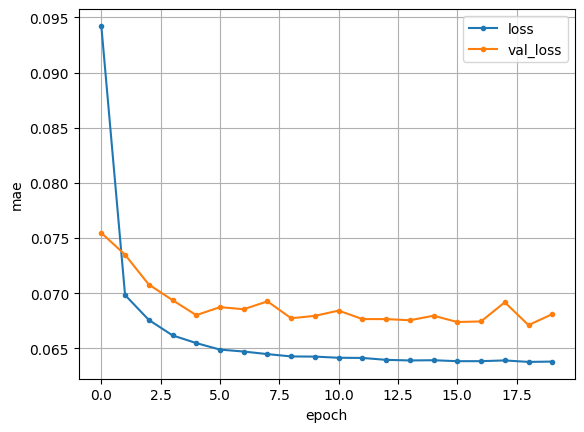

In [14]:
''' train the multi input model'''

my_multi_input = build_multi_input(timesteps=24)
my_multi_input.compile(loss='mae',
                       optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-5))

hist = my_multi_input.fit(x = [training_samples[:,:24],  # temp
                               training_samples_humidity[:,:24]], # hum
                          y = combined_target,
                          batch_size = 128,
                          epochs = 20,
                          validation_split=0.05,
                          verbose=1)

plt.plot(hist.history['loss'],label='loss',marker='.')
plt.plot(hist.history['val_loss'],label='val_loss',marker='.')
plt.legend(); plt.grid(); plt.xlabel('epoch'); plt.ylabel('mae');

In [15]:
# quick prediction on 10000 samples from the training dataset

# *NOTE: we are using the training dataset because:
#    1) we didn't separate out a testing dataset
#    2) our model doesn't appear to me overfitting
multi_preds = my_multi_input.predict([training_samples[:10000,:24],  # temp
                                      training_samples_humidity[:10000,:24]]) # hum
multi_preds.shape


313/313 [==============================] - 1s 2ms/step


(10000, 2)

Text(0.5, 0, 'hour')

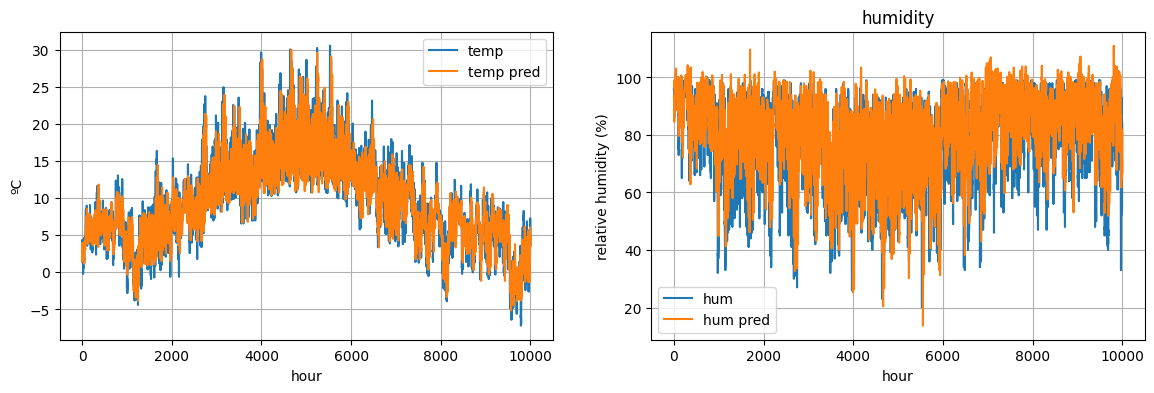

In [17]:
fig,ax = plt.subplots(1,2,figsize=(14,4))
# * 40 puts the temperatures (and predictions) back into ºC scale
ax[0].plot(training_samples[:10000,-1]*40, label='temp')
ax[0].plot(multi_preds[:,0]*40,label='temp pred')
ax[0].grid()
ax[0].legend()
ax[0].set_ylabel('ºC')
ax[0].set_xlabel('hour')

ax[1].plot(training_samples_humidity[:10000,-1]*100,label='hum')
ax[1].plot(multi_preds[:,1]*100,label='hum pred')
ax[1].grid()
ax[1].legend()
ax[1].set_title('humidity')
ax[1].set_ylabel('relative humidity (%)')
ax[1].set_xlabel('hour')

Text(0.5, 0, 'humidity error (%)')

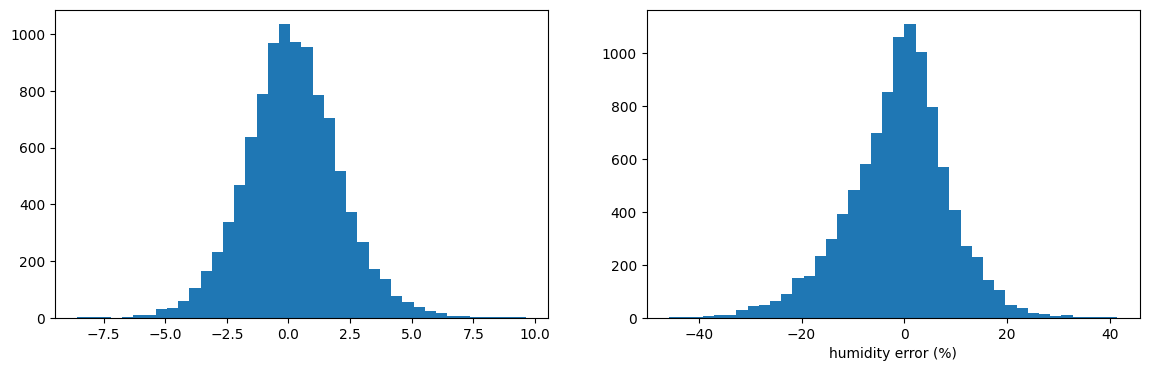

In [28]:
fig,ax=plt.subplots(1,2,figsize=(14,4))

ax[0].hist(training_samples[:10000,-1]*40 - multi_preds[:,0]*40,bins=40)
ax[1].set_xlabel('temperature error (ºC)')

ax[1].hist(training_samples_humidity[:10000,-1]*100 - multi_preds[:,1]*100,bins=40)
ax[1].set_xlabel('humidity error (%)')

In [31]:
# define a recurrent model

def build_lstm(timesteps):
    xin = tf.keras.layers.Input((timesteps))
    x0 = tf.keras.layers.Reshape((-1,1))(xin) # this layer adds a feature channel to the input

    x0 = tf.keras.layers.LSTM(64)(x0) # an LSTM layer expects shape (None, timesteps, # features)
    x0 = tf.keras.layers.Dense(64,activation='swish')(x0)

    x0 = tf.keras.layers.Dense(1)(x0)
    return tf.keras.models.Model(xin,x0)

build_lstm(timesteps=24).summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 24)]              0         
                                                                 
 reshape_6 (Reshape)         (None, 24, 1)             0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 21121 (82.50 KB)
Trainable params: 21121 (82.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/40
715/715 [==============================] - 7s 6ms/step - loss: 0.0556 - val_loss: 0.0456
Epoch 2/40
715/715 [==============================] - 4s 5ms/step - loss: 0.0444 - val_loss: 0.0444
Epoch 3/40
715/715 [==============================] - 3s 5ms/step - loss: 0.0430 - val_loss: 0.0418
Epoch 4/40
715/715 [==============================] - 4s 6ms/step - loss: 0.0423 - val_loss: 0.0406
Epoch 5/40
715/715 [==============================] - 3s 5ms/step - loss: 0.0420 - val_loss: 0.0410
Epoch 6/40
715/715 [==============================] - 3s 5ms/step - loss: 0.0417 - val_loss: 0.0404
Epoch 7/40
715/715 [==============================] - 4s 6ms/step - loss: 0.0416 - val_loss: 0.0397
Epoch 8/40
715/715 [==============================] - 4s 6ms/step - loss: 0.0411 - val_loss: 0.0410
Epoch 9/40
715/715 [==============================] - 3s 5ms/step - loss: 0.0411 - val_loss: 0.0398
Epoch 10/40
715/715 [==============================] - 4s 5ms/step - loss: 0.0410 - val_loss: 0.0388

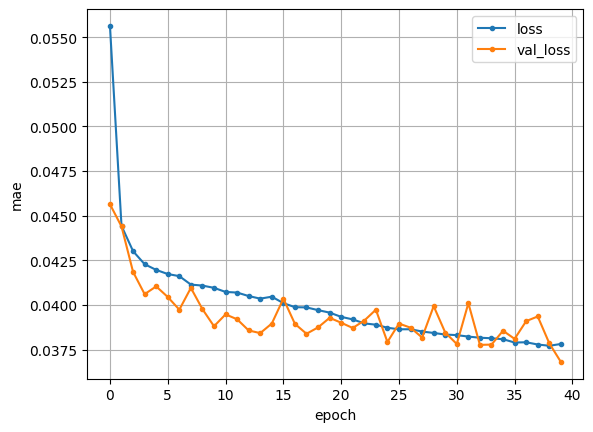

In [35]:
''' train the recurrent model'''

my_lstm = build_lstm(timesteps=24)

my_lstm.compile(loss='mae',
                       optimizer=tf.keras.optimizers.Adam(learning_rate = 5e-4))

hist = my_lstm.fit(x = training_samples[:,:24],
                   y = training_samples[:,-1],
                   batch_size = 64,
                   epochs = 40,
                   validation_split=0.05,
                   verbose=1)

plt.plot(hist.history['loss'],label='loss',marker='.')
plt.plot(hist.history['val_loss'],label='val_loss',marker='.')
plt.legend(); plt.grid(); plt.xlabel('epoch'); plt.ylabel('mae');

1505/1505 [==============================] - 4s 2ms/step


Text(0.5, 0, 'ºC error')

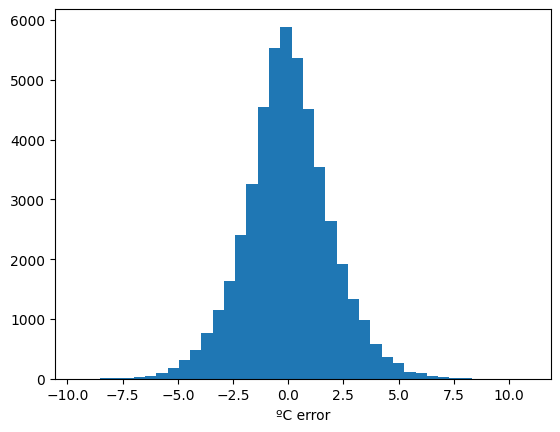

In [36]:
# make LSTM predictions

lstm_preds = my_lstm.predict(training_samples[:,:24])
lstm_preds = np.squeeze(lstm_preds) # removes dimensions with one width

plt.hist((lstm_preds - training_samples[:,-1])*40, bins=40);
plt.xlabel('ºC error')

## Iterative Prediction

How could we use a "next hour" model to predict 15 hours into the future?

Iteratively. Make a prediction, then use that as input.

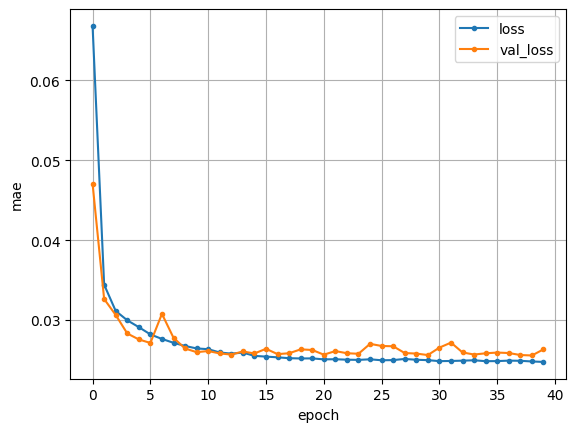

In [37]:
''' train a simple nn with no normalization, scaling, residual to demonstrate iterative technique '''

# define a model
my_lstm_iterator = build_lstm(timesteps=24)

# compile
my_lstm_iterator.compile(loss='mae',
                         optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4))

# train
hist = my_lstm_iterator.fit(x = training_samples[:, :24], # (samples, timesteps)
                  # NOTE: the targetted temperature is ONE timestep ahead (unlike everything above)
                  y = training_samples[:, 25],
                  batch_size = 64,
                  epochs = 40,
                  validation_split=0.05,
                  verbose=0)

plt.plot(hist.history['loss'],label='loss',marker='.')
plt.plot(hist.history['val_loss'],label='val_loss',marker='.')
plt.legend(); plt.grid();plt.ylabel('mae');plt.xlabel('epoch');

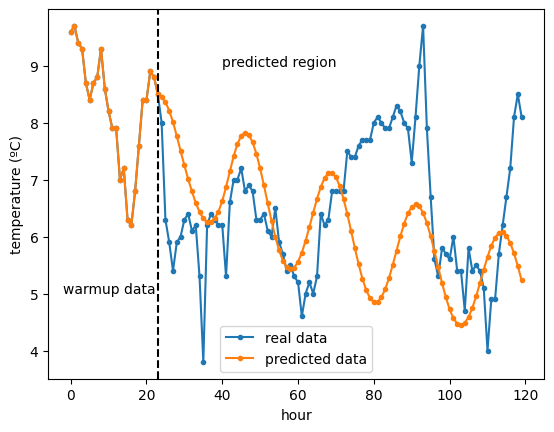

In [43]:
# with the model trained:
# use known data to start making prediction, then iterate some number of times

steps_forward = 96 # hours ahead
starting_point = 400 # hours from jan 2018

running_prediction = np.zeros((24+steps_forward))
running_prediction[:24] = data_df['Temp (ºC)'][starting_point:starting_point+24]/40

for k in range(steps_forward):
  temp_pred = my_lstm_iterator.predict(running_prediction[k:k+24].reshape(1,-1),verbose=0).squeeze()   # add batch dimension
  running_prediction[k+24] = temp_pred # add prediction to "running_prediction"

plt.plot(np.arange(24+steps_forward),
         data_df['Temp (ºC)'][starting_point:starting_point+24+steps_forward],
         marker='.',label='real data')
plt.plot(running_prediction * 40 ,marker='.',label='predicted data')
plt.xlabel('hour')
plt.ylabel('temperature (ºC)')
plt.axvline(23,ls='--',c='k',label='')
plt.text(-2,5,'warmup data')
plt.text(40,9,'predicted region')
plt.legend()